# Initial Exploration

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Assuming Google Drive is already mounted; no need to remount.

# Step 2: Load Processed Dataset with Topic Labels
import pandas as pd

# Define path to your processed dataset
dataset_path = '/content/drive/MyDrive/BERTTopic_Models/paraphrase-MiniLM-L6-v2/processed_novels_with_labels.csv'

# Load the dataset
df_sentences = pd.read_csv(dataset_path)

# Step 3: Prepare Topic Distribution Matrix

# Filter out any noisy topics if needed
noisy_topics_to_exclude = [-1, 76, 117, 165, 190]
df_filtered = df_sentences[~df_sentences['topic'].isin(noisy_topics_to_exclude)]

# Create topic distribution for each book
# Count the frequency of each topic per book, normalize by total sentences per book
topic_distribution = df_filtered.groupby(['Book_Title', 'topic']).size().unstack(fill_value=0)

# Normalize the frequency matrix (to create probabilities or proportions)
topic_distribution_normalized = topic_distribution.div(topic_distribution.sum(axis=1), axis=0)

# Step 4: Calculate Cosine Similarity Between Books

from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(topic_distribution_normalized)

# Convert cosine similarity matrix into a DataFrame for easy interpretation
similarity_df = pd.DataFrame(cosine_sim_matrix, index=topic_distribution_normalized.index, columns=topic_distribution_normalized.index)

# Step 5: Perform Clustering Based on Similarity

from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Perform hierarchical clustering
linkage_matrix = linkage(1 - cosine_sim_matrix, method='ward')  # 1 - cosine_sim as similarity measure

# Define a similarity threshold for clustering
threshold = 0.5  # Adjust threshold based on desired clustering granularity

# Extract cluster labels for each book
cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Add cluster labels to the topic distribution DataFrame
topic_distribution_normalized['Cluster_Label'] = cluster_labels
topic_distribution_normalized = topic_distribution_normalized.reset_index()

# Ensure only numeric columns are included in analysis
df_topic_distribution = topic_distribution_normalized.select_dtypes(include=[float, int]).copy()
df_topic_distribution['Book_Title'] = topic_distribution_normalized['Book_Title']

# Step 6: Identify Representative Books per Cluster

# Calculate average similarity within each cluster to find representative (centroid) books for each cluster
cluster_groups = df_topic_distribution.groupby('Cluster_Label')
representative_books = []

for cluster, group in cluster_groups:
    cluster_books = group['Book_Title']
    cluster_sim_matrix = similarity_df.loc[cluster_books, cluster_books]
    avg_similarity_within_cluster = cluster_sim_matrix.mean(axis=1)
    centroid_book = avg_similarity_within_cluster.idxmax()
    representative_books.append((cluster, centroid_book, avg_similarity_within_cluster[centroid_book]))

# Convert to DataFrame for representative books
df_representative_books = pd.DataFrame(representative_books, columns=['Cluster', 'Representative_Book', 'Average_Similarity'])

# Step 7: Label Clusters Based on Representative Books
cluster_labels = {}

for index, row in df_representative_books.iterrows():
    cluster = row['Cluster']
    representative_book = row['Representative_Book']
    book_distribution = df_topic_distribution[df_topic_distribution['Book_Title'] == representative_book].drop(columns=['Book_Title', 'Cluster_Label'])
    top_topics = book_distribution.values.flatten().argsort()[-5:][::-1]
    cluster_labels[cluster] = f"Top topics: {top_topics.tolist()}"

df_cluster_labels = pd.DataFrame(list(cluster_labels.items()), columns=['Cluster', 'Label'])

# Step 8: Cross-Cluster Similarity Analysis
cross_cluster_similarities = []

for book in similarity_df.index:
    book_cluster = df_topic_distribution.loc[df_topic_distribution['Book_Title'] == book, 'Cluster_Label'].values[0]
    similar_books = similarity_df[book].sort_values(ascending=False)
    for other_book in similar_books.index:
        other_cluster = df_topic_distribution.loc[df_topic_distribution['Book_Title'] == other_book, 'Cluster_Label'].values[0]
        if other_cluster != book_cluster:
            cross_cluster_similarities.append((book, other_book, book_cluster, other_cluster, similar_books[other_book]))
            break

df_cross_cluster_similarities = pd.DataFrame(cross_cluster_similarities, columns=['Book', 'Similar_Book', 'Book_Cluster', 'Similar_Book_Cluster', 'Similarity_Score'])

# Step 9: Dominant Topics by Cluster
# Re-select only numeric columns for grouping to avoid errors
average_topic_distribution_by_cluster = df_topic_distribution.drop(columns=['Book_Title']).groupby('Cluster_Label').mean()
dominant_topics_by_cluster = []

for cluster, row in average_topic_distribution_by_cluster.iterrows():
    top_topics = row.argsort()[-5:][::-1]
    dominant_topics_by_cluster.append((cluster, top_topics.tolist()))

df_dominant_topics_by_cluster = pd.DataFrame(dominant_topics_by_cluster, columns=['Cluster', 'Top_Dominant_Topics'])

# Step 10: Outlier Detection Within Clusters
outliers = []
for cluster, group in cluster_groups:
    book_titles = group['Book_Title']
    cluster_topic_dist = group.drop(columns=['Book_Title', 'Cluster_Label'])
    cluster_mean_topic_dist = cluster_topic_dist.mean()
    cluster_book_similarities = cosine_similarity(cluster_topic_dist, [cluster_mean_topic_dist]).flatten()
    similarity_series = pd.Series(cluster_book_similarities, index=book_titles)
    outliers_in_cluster = similarity_series.nsmallest(3)
    for book, similarity_score in outliers_in_cluster.items():
        outliers.append((book, cluster, similarity_score))

df_outliers = pd.DataFrame(outliers, columns=['Book', 'Cluster_Label', 'Similarity_to_Cluster_Mean'])

# Step 11: Enhanced Recommendation System
enhanced_recommendations = []

for book in similarity_df.index:
    book_cluster = df_topic_distribution.loc[df_topic_distribution['Book_Title'] == book, 'Cluster_Label'].values[0]
    cluster_books = df_topic_distribution[df_topic_distribution['Cluster_Label'] == book_cluster]['Book_Title']
    similar_books = similarity_df.loc[book, cluster_books].drop(book).sort_values(ascending=False)
    recommendations = similar_books.head(3)
    for recommended_book, similarity_score in recommendations.items():
        enhanced_recommendations.append((book, recommended_book, book_cluster, similarity_score))

df_enhanced_recommendations = pd.DataFrame(enhanced_recommendations, columns=['Book', 'Recommended_Book', 'Cluster', 'Similarity_Score'])


In [5]:
# Display the cluster labels with top topics for each representative book
print("Cluster Labels based on Representative Books:")
print(df_cluster_labels)

# Display the representative books for each cluster
print("\nRepresentative Books per Cluster:")
print(df_representative_books)

Cluster Labels based on Representative Books:
    Cluster                           Label
0         1   Top topics: [18, 4, 84, 1, 7]
1         2   Top topics: [23, 18, 4, 0, 7]
2         3   Top topics: [4, 6, 23, 24, 0]
3         4    Top topics: [56, 4, 0, 7, 6]
4         5   Top topics: [4, 23, 7, 18, 0]
5         6   Top topics: [1, 4, 7, 18, 24]
6         7   Top topics: [4, 7, 0, 18, 27]
7         8   Top topics: [18, 23, 0, 4, 7]
8         9  Top topics: [4, 23, 164, 0, 5]
9        10     Top topics: [6, 7, 1, 0, 4]
10       11    Top topics: [4, 6, 0, 7, 23]
11       12    Top topics: [4, 6, 7, 0, 24]
12       13    Top topics: [4, 6, 0, 24, 7]
13       14   Top topics: [7, 4, 0, 18, 10]
14       15    Top topics: [7, 1, 4, 18, 0]
15       16    Top topics: [7, 4, 0, 9, 71]
16       17    Top topics: [7, 0, 4, 11, 5]
17       18     Top topics: [7, 0, 1, 4, 5]
18       19    Top topics: [7, 4, 0, 1, 24]
19       20     Top topics: [7, 4, 6, 0, 1]
20       21    Top topics: [4,

In [6]:
# Display cross-cluster similarities to see connections between different clusters
print("\nCross-Cluster Similarities:")
print(df_cross_cluster_similarities.head())


Cross-Cluster Similarities:
                                    Book             Similar_Book  \
0                     A Long Time Coming          Blue Eyed Devil   
1                     A Not So Meet Cute            Brutal Secret   
2                           Ache for You                   Tycoon   
3  An Accidental Date with a Billionaire  The Bastard Billionaire   
4                               Bad Boss  Tapping The Billionaire   

   Book_Cluster  Similar_Book_Cluster  Similarity_Score  
0            20                    19          0.973309  
1            29                    28          0.934413  
2            31                    30          0.943501  
3            22                    21          0.964923  
4            35                    34          0.957790  


In [7]:
# Display dominant topics for each cluster to understand the main themes
print("\nDominant Topics by Cluster:")
print(df_dominant_topics_by_cluster)


Dominant Topics by Cluster:
    Cluster Top_Dominant_Topics
0         1   [18, 4, 84, 1, 7]
1         2   [23, 18, 4, 0, 7]
2         3   [4, 24, 23, 0, 6]
3         4    [56, 4, 0, 7, 6]
4         5  [4, 7, 18, 23, 24]
5         6    [4, 1, 7, 18, 0]
6         7   [4, 7, 0, 18, 27]
7         8   [23, 4, 7, 0, 18]
8         9  [4, 23, 164, 0, 5]
9        10     [6, 7, 0, 4, 1]
10       11     [4, 0, 6, 7, 1]
11       12     [6, 4, 7, 0, 1]
12       13    [4, 6, 24, 0, 7]
13       14    [7, 4, 0, 18, 6]
14       15    [7, 4, 1, 0, 18]
15       16    [7, 4, 0, 9, 71]
16       17   [7, 0, 4, 11, 23]
17       18     [7, 0, 1, 4, 5]
18       19    [7, 4, 0, 1, 23]
19       20     [7, 4, 6, 0, 1]
20       21    [4, 0, 7, 23, 1]
21       22    [4, 7, 0, 23, 1]
22       23    [4, 7, 6, 18, 0]
23       24   [4, 7, 0, 23, 15]
24       25    [4, 7, 0, 23, 1]
25       26    [7, 4, 0, 1, 24]
26       27    [7, 4, 0, 23, 1]
27       28     [7, 4, 6, 0, 9]
28       29    [7, 4, 0, 1, 23]
29       30

In [8]:
# Display outliers in each cluster with low similarity to the cluster mean
print("\nOutliers within Clusters:")
print(df_outliers.head())


Outliers within Clusters:
                        Book  Cluster_Label  Similarity_to_Cluster_Mean
0                  Devotion               1                    1.000000
1  Unmasking the Billionaire              2                    1.000000
2       The Tycoon's Revenge              3                    0.953091
3      The Tycoon's Proposal              3                    0.957368
4      The Tycoon's Vacation              3                    0.964595


In [9]:
# Display the enhanced recommendations for each book
print("\nEnhanced Book Recommendations:")
print(df_enhanced_recommendations.head())


Enhanced Book Recommendations:
                                    Book                     Recommended_Book  \
0                     A Not So Meet Cute                   So Not Meant To Be   
1                     A Not So Meet Cute  The Billionaire's Wake-up-call Girl   
2                     A Not So Meet Cute                         Brooklynaire   
3                           Ache for You                         Burn for You   
4  An Accidental Date with a Billionaire                      The Wright Boss   

   Cluster  Similarity_Score  
0       29          0.956504  
1       29          0.931020  
2       29          0.899088  
3       31          0.919409  
4       22          0.956150  


In [10]:
# Extract topic labels and IDs from the main CSV if available
topic_labels_path = '/content/drive/MyDrive/BERTTopic_Models/paraphrase-MiniLM-L6-v2/topics_5_20241102_205523/labels_bertopic_model_5_iter_19_paraphrase-MiniLM-L6-v2_20241102_205523_topics_info.csv'
df_topic_labels = pd.read_csv(topic_labels_path)
df_topic_labels = df_topic_labels[['Topic', 'Label']]

# Map topics to labels for better readability in each cluster
df_dominant_topics_by_cluster_labeled = df_dominant_topics_by_cluster.copy()
df_dominant_topics_by_cluster_labeled['Top_Dominant_Topics'] = df_dominant_topics_by_cluster_labeled['Top_Dominant_Topics'].apply(
    lambda topics: [f"{topic_id}: {df_topic_labels[df_topic_labels['Topic'] == topic_id]['Label'].values[0]}" if topic_id in df_topic_labels['Topic'].values else str(topic_id)
                    for topic_id in topics]
)

# Save to CSV for further manual labeling
output_path = '/content/drive/MyDrive/BERTTopic_Models/cluster_dominant_topics_with_labels.csv'
df_dominant_topics_by_cluster_labeled.to_csv(output_path, index=False)
print(f"CSV with cluster dominant topics and labels saved to {output_path}")

CSV with cluster dominant topics and labels saved to /content/drive/MyDrive/BERTTopic_Models/cluster_dominant_topics_with_labels.csv


In [11]:
# Set the number of top topics to include for more comprehensive analysis
num_top_topics = 10  # Adjust as needed; 10 is suggested here for expanded information

# Adjust the dominant topics by cluster to include more topics and add descriptions
df_dominant_topics_expanded = df_dominant_topics_by_cluster.copy()
df_dominant_topics_expanded['Expanded_Topics'] = df_dominant_topics_expanded['Cluster'].apply(
    lambda cluster_id: (
        df_topic_distribution[df_topic_distribution['Cluster_Label'] == cluster_id]
        .drop(columns=['Book_Title', 'Cluster_Label'])
        .mean()
        .sort_values(ascending=False)
        .head(num_top_topics)
        .index.tolist()
    )
)

# Add topic labels and example sentences for each expanded topic
df_dominant_topics_expanded['Expanded_Topics_Labels'] = df_dominant_topics_expanded['Expanded_Topics'].apply(
    lambda topics: [
        f"{topic_id}: {df_topic_labels[df_topic_labels['Topic'] == topic_id]['Label'].values[0]}"
        if topic_id in df_topic_labels['Topic'].values else str(topic_id)
        for topic_id in topics
    ]
)

# Add example sentences or keywords for each topic (if available in the topic labels file)
# Assuming df_topic_labels has 'Example_Sentences' or similar column with example text per topic
if 'Example_Sentences' in df_topic_labels.columns:
    df_dominant_topics_expanded['Expanded_Topics_Examples'] = df_dominant_topics_expanded['Expanded_Topics'].apply(
        lambda topics: [
            df_topic_labels[df_topic_labels['Topic'] == topic_id]['Example_Sentences'].values[0]
            if topic_id in df_topic_labels['Topic'].values else ""
            for topic_id in topics
        ]
    )

# Save the expanded topic data to CSV for manual inspection and enhanced analysis
expanded_output_path = '/content/drive/MyDrive/BERTTopic_Models/expanded_cluster_topics_with_labels_and_examples.csv'
df_dominant_topics_expanded.to_csv(expanded_output_path, index=False)
print(f"CSV with expanded cluster topics, labels, and examples saved to {expanded_output_path}")

CSV with expanded cluster topics, labels, and examples saved to /content/drive/MyDrive/BERTTopic_Models/expanded_cluster_topics_with_labels_and_examples.csv


# Topics by Broader Thematic Gropus

Map Topics to Broader Themes: Create a mapping dictionary that groups each topic into a broader theme. This mapping will allow us to aggregate topic data for each book based on theme rather than individual topic.

Calculate Theme Distributions for Each Book: Using the mapping, calculate the frequency of each broader theme for each book, creating a “theme profile” for each book.

Cluster Books by Theme Profiles: Use cosine similarity and hierarchical clustering based on these theme profiles to group books by thematic similarity.

In [19]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster

In [20]:
# Define the path to the dataset
dataset_path = '/content/drive/MyDrive/BERTTopic_Models/paraphrase-MiniLM-L6-v2/processed_novels_with_labels.csv'

# Load the dataset and display the first few rows to verify structure
df_sentences = pd.read_csv(dataset_path)
print("Dataset structure:")
print(df_sentences.head())

Dataset structure:
     Author               Book_Title  Chapter  \
0  Ann_Cole  Mr. Mysterious In Black        1   
1  Ann_Cole  Mr. Mysterious In Black        1   
2  Ann_Cole  Mr. Mysterious In Black        1   
3  Ann_Cole  Mr. Mysterious In Black        1   
4  Ann_Cole  Mr. Mysterious In Black        1   

                                            Sentence  topic  \
0                            Prologue H e was tired.    210   
1                                         Dog-tired.    210   
2  Amped up by pleasure mere minutes ago, his hea...     20   
3  Unfortunately, he was yanked back from the bec...     23   
4  Languid, he opened his eyes to the annoying re...     -1   

                                   topic_probability  Topic  \
0  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...    210   
1  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...    210   
2  [0.0017705  0.00184171 0.00216719 0.00173465 0...     20   
3  [0.00237123 0.00262983 0.00200518 0.00196397 0...   

In [21]:
# Define noisy topics to exclude
noisy_topics_to_exclude = [-1, 76, 117, 165, 190]

# Filter the DataFrame to remove rows with noisy topics
df_filtered = df_sentences[~df_sentences['topic'].isin(noisy_topics_to_exclude)].copy()

print("Filtered dataset (no noisy topics):")
print(df_filtered.head())

Filtered dataset (no noisy topics):
     Author               Book_Title  Chapter  \
0  Ann_Cole  Mr. Mysterious In Black        1   
1  Ann_Cole  Mr. Mysterious In Black        1   
2  Ann_Cole  Mr. Mysterious In Black        1   
3  Ann_Cole  Mr. Mysterious In Black        1   
6  Ann_Cole  Mr. Mysterious In Black        1   

                                            Sentence  topic  \
0                            Prologue H e was tired.    210   
1                                         Dog-tired.    210   
2  Amped up by pleasure mere minutes ago, his hea...     20   
3  Unfortunately, he was yanked back from the bec...     23   
6  His eyes skidded over the olive-skinned, plati...      8   

                                   topic_probability  Topic  \
0  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...    210   
1  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...    210   
2  [0.0017705  0.00184171 0.00216719 0.00173465 0...     20   
3  [0.00237123 0.00262983 0.00200518 0

In [22]:
# Aggregate topic data by 'Book_Title' and 'topic' to create the topic distribution matrix
# This counts the occurrences of each topic per book
df_topic_distribution = df_filtered.groupby(['Book_Title', 'topic']).size().unstack(fill_value=0)

print("Topic distribution matrix by book:")
print(df_topic_distribution.head())

Topic distribution matrix by book:
topic                                  0    1    2    3    4    5    6    \
Book_Title                                                                 
A Long Time Coming                     224  160  106   32  311   64  263   
A Not So Meet Cute                     206  222   87   44  243   84  108   
Ache for You                           191   74   79   41  175   84   95   
An Accidental Date with a Billionaire  104   50   22   22  142   20   22   
Bad Boss                               251   44   36   35  128   47   14   

topic                                   7    8    9    ...  206  207  208  \
Book_Title                                             ...                  
A Long Time Coming                     1453   56   21  ...    2    0    2   
A Not So Meet Cute                      416   49  149  ...    3    1    6   
Ache for You                            345   42   32  ...    5    1    3   
An Accidental Date with a Billionaire   111   2

In [23]:
# Define a dictionary mapping each topic to its broader theme
topic_to_theme = {
    # Happy Emotions, Calm and Peace
    0: 'Happy Emotions, Calm and Peace', 201: 'Happy Emotions, Calm and Peace', 84: 'Happy Emotions, Calm and Peace',
    121: 'Happy Emotions, Calm and Peace', 179: 'Happy Emotions, Calm and Peace', 183: 'Happy Emotions, Calm and Peace', 213: 'Happy Emotions, Calm and Peace',

    # Inner Conflicts and Decisions
    4: 'Inner Conflicts and Decisions', 215: 'Inner Conflicts and Decisions', 155: 'Inner Conflicts and Decisions',
    204: 'Inner Conflicts and Decisions', 178: 'Inner Conflicts and Decisions', 141: 'Inner Conflicts and Decisions',
    157: 'Inner Conflicts and Decisions', 164: 'Inner Conflicts and Decisions', 101: 'Inner Conflicts and Decisions',
    120: 'Inner Conflicts and Decisions', 143: 'Inner Conflicts and Decisions', 148: 'Inner Conflicts and Decisions',
    203: 'Inner Conflicts and Decisions', 146: 'Inner Conflicts and Decisions',

    # Vulnerability, Anxiety and Fear
    31: 'Vulnerability, Anxiety and Fear', 38: 'Vulnerability, Anxiety and Fear', 46: 'Vulnerability, Anxiety and Fear',
    131: 'Vulnerability, Anxiety and Fear', 67: 'Vulnerability, Anxiety and Fear', 210: 'Vulnerability, Anxiety and Fear',

    # Anger and Frustration
    37: 'Anger and Frustration', 152: 'Anger and Frustration', 191: 'Anger and Frustration', 174: 'Anger and Frustration',
    42: 'Anger and Frustration', 66: 'Anger and Frustration', 138: 'Anger and Frustration', 113: 'Anger and Frustration',
    119: 'Anger and Frustration',

    # Guilt and Betrayal
    49: 'Guilt and Betrayal', 126: 'Guilt and Betrayal', 46: 'Guilt and Betrayal', 130: 'Guilt and Betrayal',

    # Commitment and Engagement
    6: 'Commitment and Engagement', 112: 'Commitment and Engagement',

    # Highly Explicit Erotic
    13: 'Highly Explicit Erotic', 43: 'Highly Explicit Erotic', 52: 'Highly Explicit Erotic', 53: 'Highly Explicit Erotic',
    18: 'Highly Explicit Erotic', 102: 'Highly Explicit Erotic', 182: 'Highly Explicit Erotic', 198: 'Highly Explicit Erotic',
    199: 'Highly Explicit Erotic', 110: 'Highly Explicit Erotic',

    # Softer Erotic
    8: 'Softer Erotic', 23: 'Softer Erotic', 30: 'Softer Erotic', 41: 'Softer Erotic', 65: 'Softer Erotic',
    74: 'Softer Erotic', 125: 'Softer Erotic', 40: 'Softer Erotic', 10: 'Softer Erotic', 133: 'Softer Erotic',
    55: 'Softer Erotic', 193: 'Softer Erotic', 45: 'Softer Erotic', 59: 'Softer Erotic', 200: 'Softer Erotic',

    # Courtship and Flirting
    1: 'Courtship and Flirting', 85: 'Courtship and Flirting', 86: 'Courtship and Flirting', 71: 'Courtship and Flirting',
    166: 'Courtship and Flirting', 167: 'Courtship and Flirting', 168: 'Courtship and Flirting', 169: 'Courtship and Flirting',
    205: 'Courtship and Flirting', 72: 'Courtship and Flirting',

    # Cozy Romantic Settings
    214: 'Cozy Romantic Settings', 77: 'Cozy Romantic Settings', 158: 'Cozy Romantic Settings', 161: 'Cozy Romantic Settings',
    78: 'Cozy Romantic Settings', 123: 'Cozy Romantic Settings', 135: 'Cozy Romantic Settings', 107: 'Cozy Romantic Settings',

    # Communication
    14: 'Communication', 11: 'Communication', 106: 'Communication', 7: 'Communication', 36: 'Communication',
    10: 'Communication', 64: 'Communication', 61: 'Communication',

    # Domestic Environment
    2: 'Domestic Environment', 5: 'Domestic Environment', 76: 'Domestic Environment', 173: 'Domestic Environment',
    25: 'Domestic Environment', 28: 'Domestic Environment', 163: 'Domestic Environment', 22: 'Domestic Environment',
    136: 'Domestic Environment', 88: 'Domestic Environment', 118: 'Domestic Environment', 132: 'Domestic Environment',

    # Clothes and Appearance
    26: 'Clothes and Appearance', 145: 'Clothes and Appearance', 142: 'Clothes and Appearance', 154: 'Clothes and Appearance',
    92: 'Clothes and Appearance', 69: 'Clothes and Appearance',

    # Sensory Experiences
    55: 'Sensory Experiences', 57: 'Sensory Experiences', 73: 'Sensory Experiences', 139: 'Sensory Experiences',
    193: 'Sensory Experiences', 54: 'Sensory Experiences', 210: 'Sensory Experiences',

    # Facial Expressions
    66: 'Facial Expressions', 69: 'Facial Expressions', 73: 'Facial Expressions', 138: 'Facial Expressions',

    # Luxury Living
    33: 'Luxury Living', 185: 'Luxury Living', 115: 'Luxury Living', 78: 'Luxury Living', 211: 'Luxury Living',
    26: 'Luxury Living', 81: 'Luxury Living', 104: 'Luxury Living', 144: 'Luxury Living', 154: 'Luxury Living',
    58: 'Luxury Living', 82: 'Luxury Living', 145: 'Luxury Living', 142: 'Luxury Living', 208: 'Luxury Living',
    47: 'Luxury Living', 44: 'Luxury Living', 189: 'Luxury Living', 172: 'Luxury Living', 176: 'Luxury Living', 3: 'Luxury Living',

    # Financial and Professional Aspects
    9: 'Financial and Professional Aspects', 109: 'Financial and Professional Aspects', 185: 'Financial and Professional Aspects',
    21: 'Financial and Professional Aspects', 29: 'Financial and Professional Aspects', 111: 'Financial and Professional Aspects',
    17: 'Financial and Professional Aspects', 98: 'Financial and Professional Aspects', 100: 'Financial and Professional Aspects',
    181: 'Financial and Professional Aspects', 206: 'Financial and Professional Aspects', 186: 'Financial and Professional Aspects',
    151: 'Financial and Professional Aspects', 156: 'Financial and Professional Aspects',

    # Conflict and Danger
    63: 'Conflict and Danger', 152: 'Conflict and Danger', 99: 'Conflict and Danger', 124: 'Conflict and Danger',
    197: 'Conflict and Danger', 192: 'Conflict and Danger', 140: 'Conflict and Danger', 188: 'Conflict and Danger',
    147: 'Conflict and Danger',

    # Sweat and Exercise
    108: 'Sweat and Exercise', 196: 'Sweat and Exercise', 97: 'Sweat and Exercise', 212: 'Sweat and Exercise',
    162: 'Sweat and Exercise', 153: 'Sweat and Exercise', 32: 'Sweat and Exercise', 153: 'Sweat and Exercise', 87: 'Sweat and Exercise',

    # Addictions and Vices
    127: 'Addictions and Vices', 149: 'Addictions and Vices', 15: 'Addictions and Vices', 96: 'Addictions and Vices',

    # Brutal Hero
    134: 'Brutal Hero', 202: 'Brutal Hero',

    # Medical Care
    56: 'Medical Care', 207: 'Medical Care', 184: 'Medical Care', 122: 'Medical Care',

    # Children and Pregnancy
    150: 'Children and Pregnancy',

    # Memories and Remembrance
    75: 'Memories and Remembrance', 39: 'Memories and Remembrance', 100: 'Memories and Remembrance',

    # Technology and Modern Communication
    27: 'Technology and Modern Communication', 214: 'Technology and Modern Communication',
    186: 'Technology and Modern Communication', 151: 'Technology and Modern Communication',

    # Personal Development and Growth
    194: 'Personal Development and Growth', 184: 'Personal Development and Growth', 122: 'Personal Development and Growth',
    20: 'Personal Development and Growth', 207: 'Personal Development and Growth',

    # Conflict Resolution and Sudden Realizations
    50: 'Conflict Resolution and Sudden Realizations', 177: 'Conflict Resolution and Sudden Realizations',
    49: 'Conflict Resolution and Sudden Realizations', 130: 'Conflict Resolution and Sudden Realizations',
    187: 'Conflict Resolution and Sudden Realizations', 175: 'Conflict Resolution and Sudden Realizations',
    137: 'Conflict Resolution and Sudden Realizations', 160: 'Conflict Resolution and Sudden Realizations',
    62: 'Conflict Resolution and Sudden Realizations', 137: 'Conflict Resolution and Sudden Realizations',

    # Separation and Goodbyes
    48: 'Separation and Goodbyes', 70: 'Separation and Goodbyes', 180: 'Separation and Goodbyes',
    195: 'Separation and Goodbyes', 129: 'Separation and Goodbyes',

    # Social Life (Friends and Relatives)
    24: 'Social Life (Friends and Relatives)', 35: 'Social Life (Friends and Relatives)',
    34: 'Social Life (Friends and Relatives)', 89: 'Social Life (Friends and Relatives)',
    209: 'Social Life (Friends and Relatives)',

    # Sports and Physical Activities
    32: 'Sports and Physical Activities', 171: 'Sports and Physical Activities', 212: 'Sports and Physical Activities',
    108: 'Sports and Physical Activities', 196: 'Sports and Physical Activities', 97: 'Sports and Physical Activities',

    # Leisure and Entertainment
    170: 'Leisure and Entertainment', 114: 'Leisure and Entertainment', 128: 'Leisure and Entertainment',

    # Challenges and Enemies
    203: 'Challenges and Enemies', 159: 'Challenges and Enemies', 51: 'Challenges and Enemies', 46: 'Challenges and Enemies'
}

In [25]:
# Aggregate each topic into its broader theme
for topic_col in df_topic_distribution.columns:
    if topic_col in topic_to_theme:
        theme = topic_to_theme[topic_col]
        df_theme_distribution[theme] += df_topic_distribution[topic_col]

# Display the theme distribution to verify that themes have non-zero values
print("Aggregated theme distribution:")
print(df_theme_distribution.head())

Aggregated theme distribution:
                                       Medical Care  Communication  \
Book_Title                                                           
A Long Time Coming                                3           1644   
A Not So Meet Cute                                3            621   
Ache for You                                     12            549   
An Accidental Date with a Billionaire             0            171   
Bad Boss                                          0            337   

                                       Guilt and Betrayal  \
Book_Title                                                  
A Long Time Coming                                      7   
A Not So Meet Cute                                     10   
Ache for You                                            1   
An Accidental Date with a Billionaire                   2   
Bad Boss                                                2   

                                       Cozy Romant

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Calculate cosine similarity between books based on theme distribution
cosine_sim_matrix = cosine_similarity(df_theme_distribution)

# Convert to DataFrame for easier interpretation
similarity_df = pd.DataFrame(cosine_sim_matrix, index=df_theme_distribution.index, columns=df_theme_distribution.index)

print("Cosine similarity matrix:")
print(similarity_df.head())

Cosine similarity matrix:
Book_Title                             A Long Time Coming  A Not So Meet Cute  \
Book_Title                                                                      
A Long Time Coming                               1.000000            0.887442   
A Not So Meet Cute                               0.887442            1.000000   
Ache for You                                     0.920905            0.942137   
An Accidental Date with a Billionaire            0.808160            0.945047   
Bad Boss                                         0.844577            0.937802   

Book_Title                             Ache for You  \
Book_Title                                            
A Long Time Coming                         0.920905   
A Not So Meet Cute                         0.942137   
Ache for You                               1.000000   
An Accidental Date with a Billionaire      0.930779   
Bad Boss                                   0.940878   

Book_Title          

In [28]:
# Perform hierarchical clustering using cosine distance (1 - cosine similarity)
linkage_matrix = linkage(1 - cosine_sim_matrix, method='ward')

# Set a threshold to define clusters, which can be adjusted based on analysis requirements
threshold = 0.5  # Adjust threshold based on desired cluster granularity
cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Add the cluster labels to the theme distribution DataFrame
df_theme_distribution['Cluster_Label'] = cluster_labels

print("Theme distribution with cluster labels:")
print(df_theme_distribution[['Cluster_Label']].head())

Theme distribution with cluster labels:
                                       Cluster_Label
Book_Title                                          
A Long Time Coming                                 1
A Not So Meet Cute                                 9
Ache for You                                       4
An Accidental Date with a Billionaire             11
Bad Boss                                           6


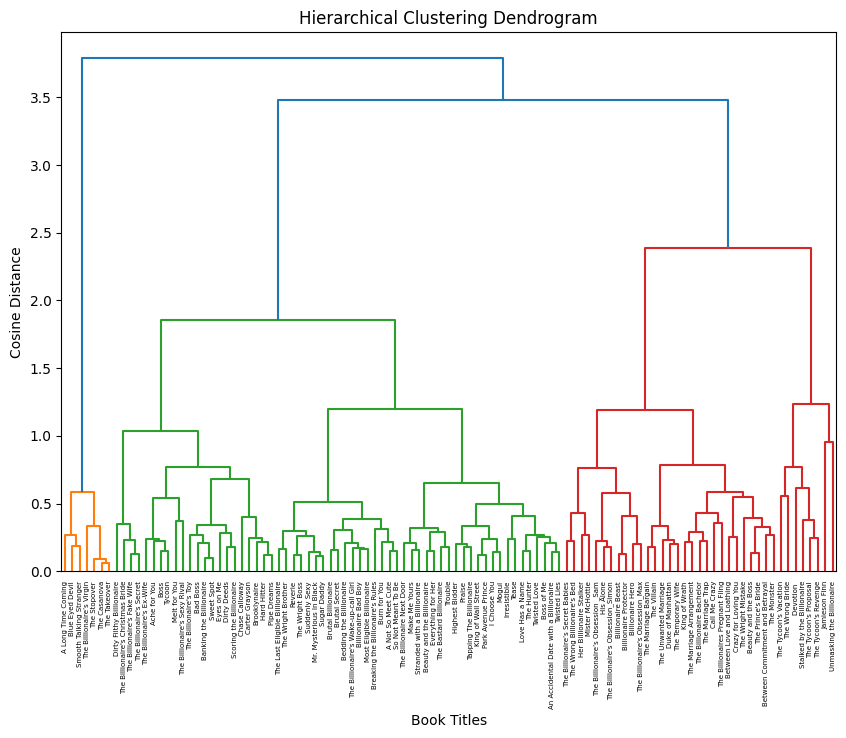

In [29]:
from scipy.cluster.hierarchy import dendrogram

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=df_theme_distribution.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Book Titles")
plt.ylabel("Cosine Distance")
plt.show()

In [30]:
# Save theme distribution with cluster labels for manual inspection or further analysis
output_path = '/content/drive/MyDrive/BERTTopic_Models/theme_clusters_with_labels.csv'
df_theme_distribution.to_csv(output_path)

print(f"Clustered theme distribution saved to {output_path}")

Clustered theme distribution saved to /content/drive/MyDrive/BERTTopic_Models/theme_clusters_with_labels.csv


In [31]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load the theme distribution data
df_theme_clusters = pd.read_csv('/content/drive/MyDrive/BERTTopic_Models/theme_clusters_with_labels.csv')

# Set Book_Title as the index for easy access to similarity matrix
df_theme_clusters.set_index('Book_Title', inplace=True)

# Remove the Cluster_Label column for similarity calculations
df_themes_only = df_theme_clusters.drop(columns=['Cluster_Label'])

# Calculate cosine similarity between books
cosine_sim_matrix = cosine_similarity(df_themes_only)

# Convert cosine similarity matrix to DataFrame for easier interpretation
similarity_df = pd.DataFrame(cosine_sim_matrix, index=df_themes_only.index, columns=df_themes_only.index)

# Display similarity matrix
print("Cosine similarity matrix:")
similarity_df.head()

Cosine similarity matrix:


Book_Title,A Long Time Coming,A Not So Meet Cute,Ache for You,An Accidental Date with a Billionaire,Bad Boss,Banking the Billionaire,Beauty and the Billionaire,Beauty and the Boss,Bedding the Billionaire,Between Commitment and Betrayal,...,The Wright Boss,The Wright Brother,The Wright Mistake,The Wrong Billionaire's Bed,The Wrong Bride,Trouble,Twisted Lies,Twisted Love,Tycoon,Unmasking the Billionaire
Book_Title,,,,,,,,,,,,,,,,,,,,,
A Long Time Coming,1.000000,0.887442,0.920905,0.808160,0.844577,0.825423,0.794629,0.798887,0.900947,0.841320,...,0.854299,0.843085,0.799233,0.742281,0.749491,0.751321,0.789860,0.806167,0.890751,0.638345
A Not So Meet Cute,0.887442,1.000000,0.942137,0.945047,0.937802,0.927136,0.968364,0.916893,0.949110,0.943018,...,0.934962,0.943378,0.889376,0.904466,0.852615,0.939127,0.939335,0.933160,0.934982,0.802641
Ache for You,0.920905,0.942137,1.000000,0.930779,0.940878,0.929188,0.893668,0.908254,0.966535,0.921120,...,0.936811,0.940127,0.911151,0.866121,0.824700,0.907930,0.934586,0.938879,0.968496,0.770363
An Accidental Date with a Billionaire,0.808160,0.945047,0.930779,1.000000,0.924906,0.926623,0.954538,0.983798,0.957111,0.925592,...,0.965203,0.965623,0.939131,0.919916,0.861263,0.967798,0.979263,0.947426,0.958125,0.846164
Bad Boss,0.844577,0.937802,0.940878,0.924906,1.000000,0.981662,0.912834,0.875558,0.945972,0.890773,...,0.926591,0.916324,0.895298,0.869622,0.800574,0.909864,0.938749,0.937714,0.962018,0.771921


In [32]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# Perform hierarchical clustering using cosine distance (1 - cosine similarity)
linkage_matrix = linkage(1 - cosine_sim_matrix, method='ward')

# Define a threshold to generate clusters
threshold = 0.5  # Adjust threshold based on the level of granularity needed
cluster_labels = fcluster(linkage_matrix, threshold, criterion='distance')

# Add cluster labels back to the main DataFrame
df_theme_clusters['Cluster_Label'] = cluster_labels

# Display cluster label assignments
print("Books with cluster labels:")
df_theme_clusters[['Cluster_Label']].head()

Books with cluster labels:


,Cluster_Label
Book_Title,
A Long Time Coming,1
A Not So Meet Cute,9
Ache for You,4
An Accidental Date with a Billionaire,11
Bad Boss,6


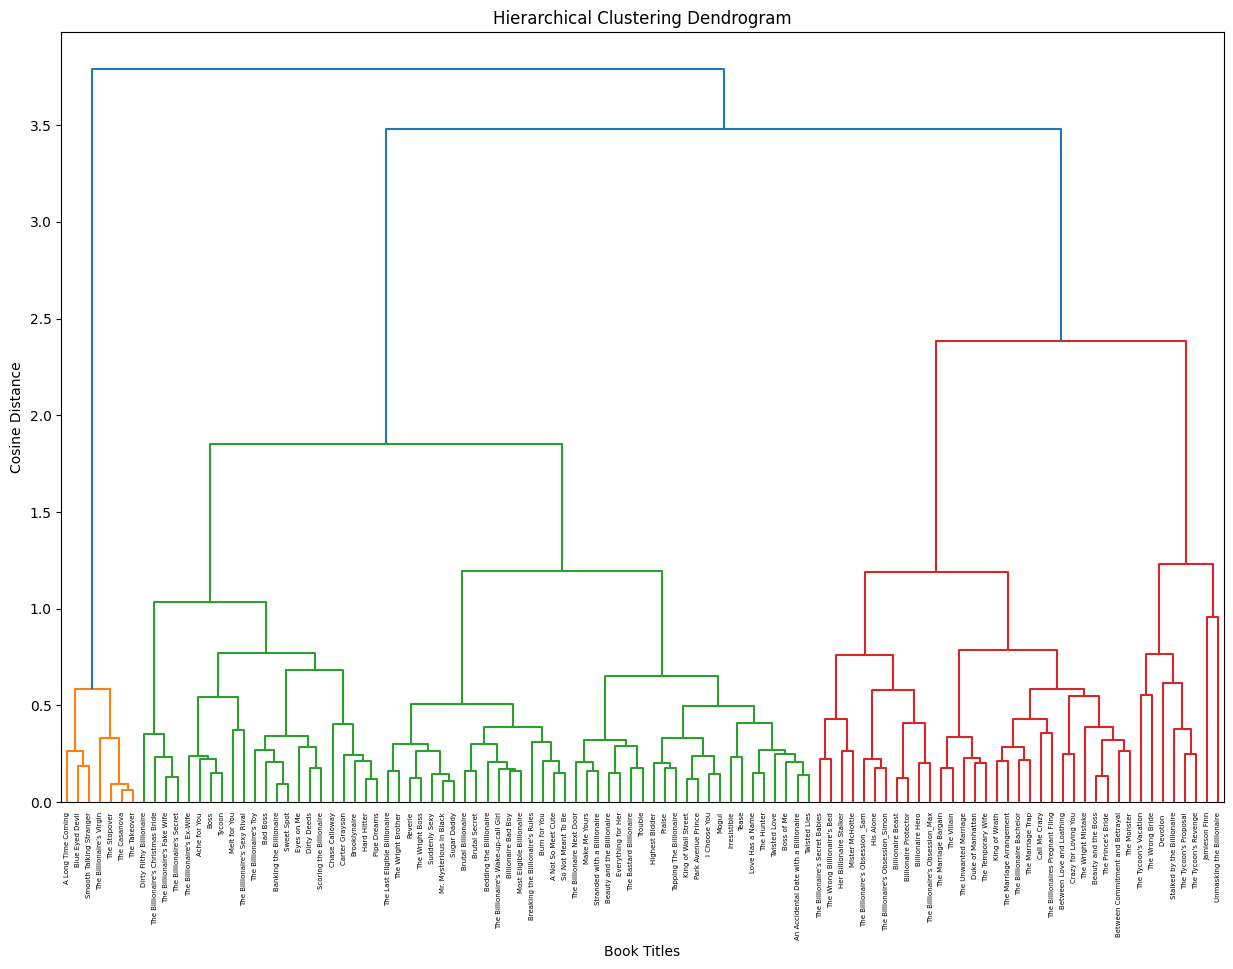

In [33]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# Plot dendrogram for hierarchical clustering visualization
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=df_themes_only.index, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Book Titles")
plt.ylabel("Cosine Distance")
plt.show()

In [34]:
# Count unique clusters and the number of books in each cluster
cluster_counts = df_theme_clusters['Cluster_Label'].value_counts().sort_index()

print("Number of clusters:", cluster_counts.shape[0])
print("Book distribution across clusters:")
print(cluster_counts)

Number of clusters: 24
Book distribution across clusters:
Cluster_Label
1      3
2      4
3      4
4      4
5      2
6      7
7      5
8      7
9     10
10     7
11    15
12     4
13     3
14     4
15     5
16     6
17     2
18     5
19     1
20     1
21     3
22     1
23     1
24     1
Name: count, dtype: int64


In [35]:
# Calculate average theme values per cluster to identify prevalent themes
cluster_theme_means = df_theme_clusters.groupby('Cluster_Label').mean()

# Drop the Cluster_Label column if it's included in the mean calculation
if 'Cluster_Label' in cluster_theme_means.columns:
    cluster_theme_means = cluster_theme_means.drop(columns=['Cluster_Label'])

print("Average theme values per cluster:")
print(cluster_theme_means.head())

Average theme values per cluster:
               Medical Care  Communication  Guilt and Betrayal  \
Cluster_Label                                                    
1                 18.666667         1390.0            7.333333   
2                 10.750000         1245.5            1.250000   
3                 19.500000          815.5            5.250000   
4                  3.500000          336.0            1.750000   
5                  5.000000          385.0            5.000000   

               Cozy Romantic Settings  Sports and Physical Activities  \
Cluster_Label                                                           
1                           30.333333                           35.00   
2                           33.000000                           29.75   
3                           16.750000                           50.75   
4                            9.750000                           23.25   
5                           12.500000                           2

In [36]:
# Identify top 5 themes per cluster for easier labeling
top_themes_by_cluster = {}
for cluster_label in cluster_theme_means.index:
    top_themes = cluster_theme_means.loc[cluster_label].nlargest(5).index.tolist()
    top_themes_by_cluster[cluster_label] = top_themes

print("Top themes per cluster:")
for cluster, themes in top_themes_by_cluster.items():
    print(f"Cluster {cluster}: {themes}")

Top themes per cluster:
Cluster 1: ['Communication', 'Inner Conflicts and Decisions', 'Happy Emotions, Calm and Peace', 'Softer Erotic', 'Domestic Environment']
Cluster 2: ['Communication', 'Happy Emotions, Calm and Peace', 'Domestic Environment', 'Softer Erotic', 'Luxury Living']
Cluster 3: ['Communication', 'Inner Conflicts and Decisions', 'Highly Explicit Erotic', 'Softer Erotic', 'Happy Emotions, Calm and Peace']
Cluster 4: ['Communication', 'Happy Emotions, Calm and Peace', 'Inner Conflicts and Decisions', 'Softer Erotic', 'Domestic Environment']
Cluster 5: ['Communication', 'Happy Emotions, Calm and Peace', 'Domestic Environment', 'Courtship and Flirting', 'Softer Erotic']
Cluster 6: ['Communication', 'Happy Emotions, Calm and Peace', 'Inner Conflicts and Decisions', 'Highly Explicit Erotic', 'Domestic Environment']
Cluster 7: ['Communication', 'Domestic Environment', 'Happy Emotions, Calm and Peace', 'Inner Conflicts and Decisions', 'Courtship and Flirting']
Cluster 8: ['Communi

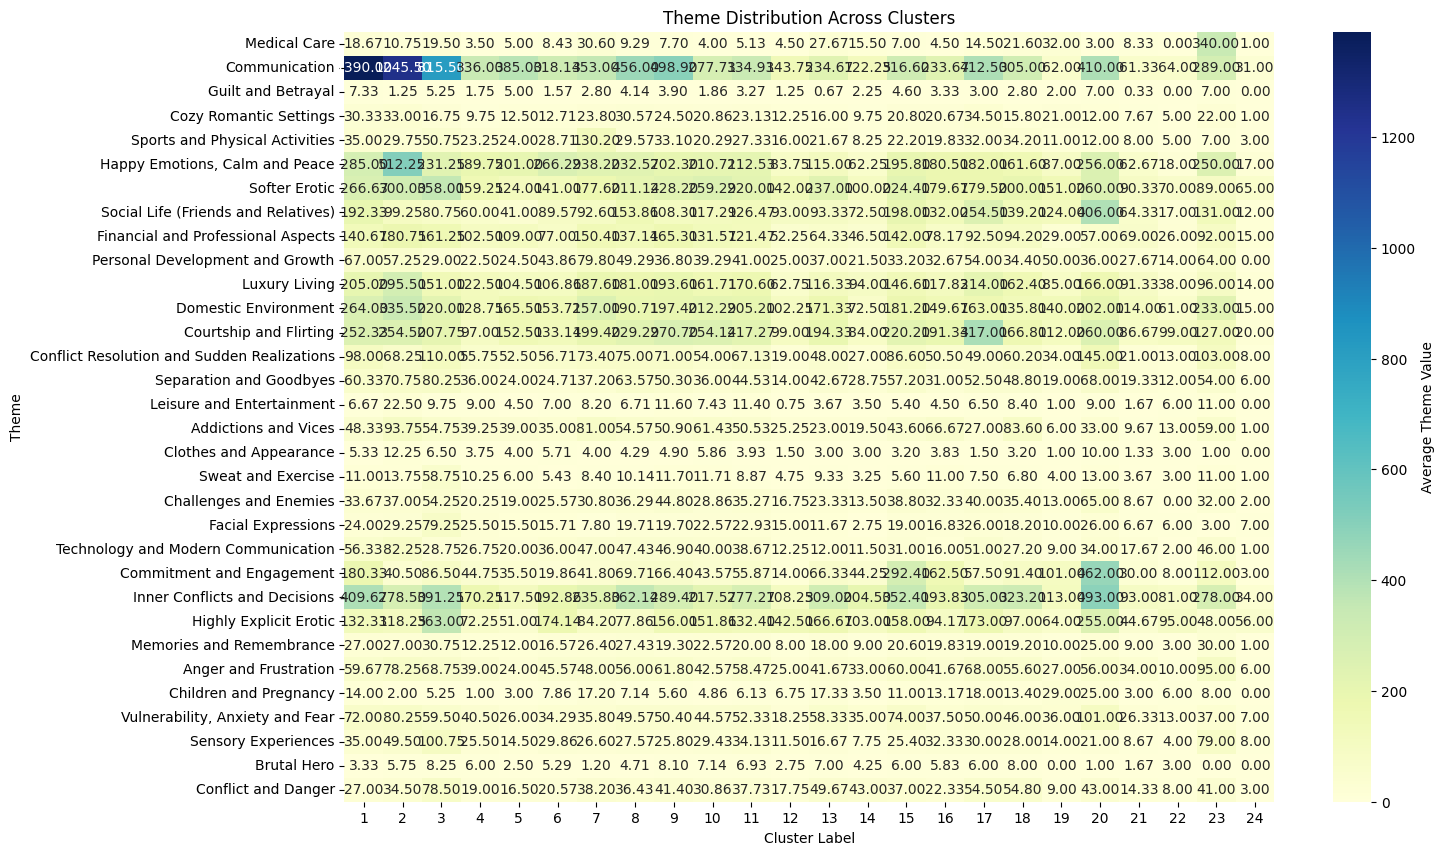

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap for theme distribution across clusters
plt.figure(figsize=(15, 10))
sns.heatmap(cluster_theme_means.T, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Average Theme Value'})
plt.title("Theme Distribution Across Clusters")
plt.xlabel("Cluster Label")
plt.ylabel("Theme")
plt.show()

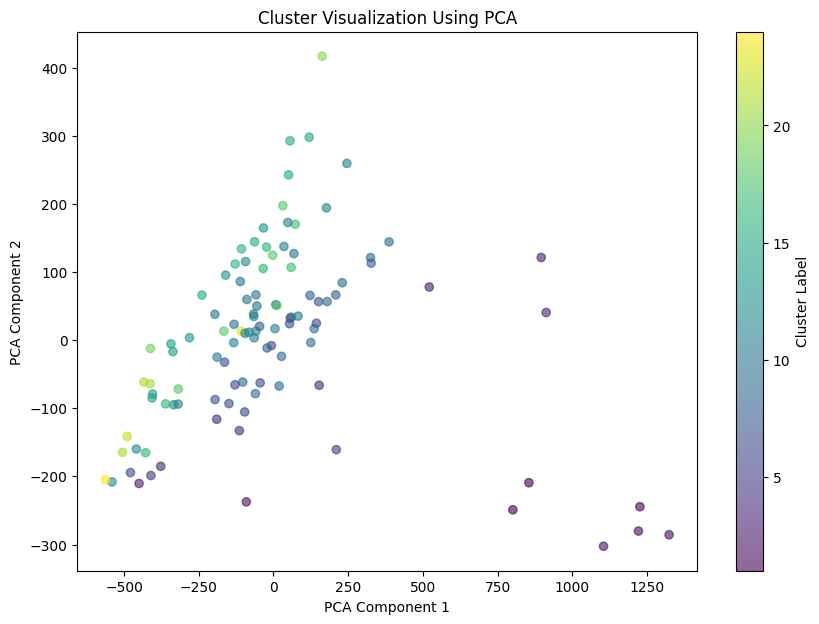

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
cluster_theme_pca = pca.fit_transform(df_theme_clusters.drop(columns=['Cluster_Label']))

# Plot PCA results for clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(cluster_theme_pca[:, 0], cluster_theme_pca[:, 1], c=df_theme_clusters['Cluster_Label'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization Using PCA")
plt.show()

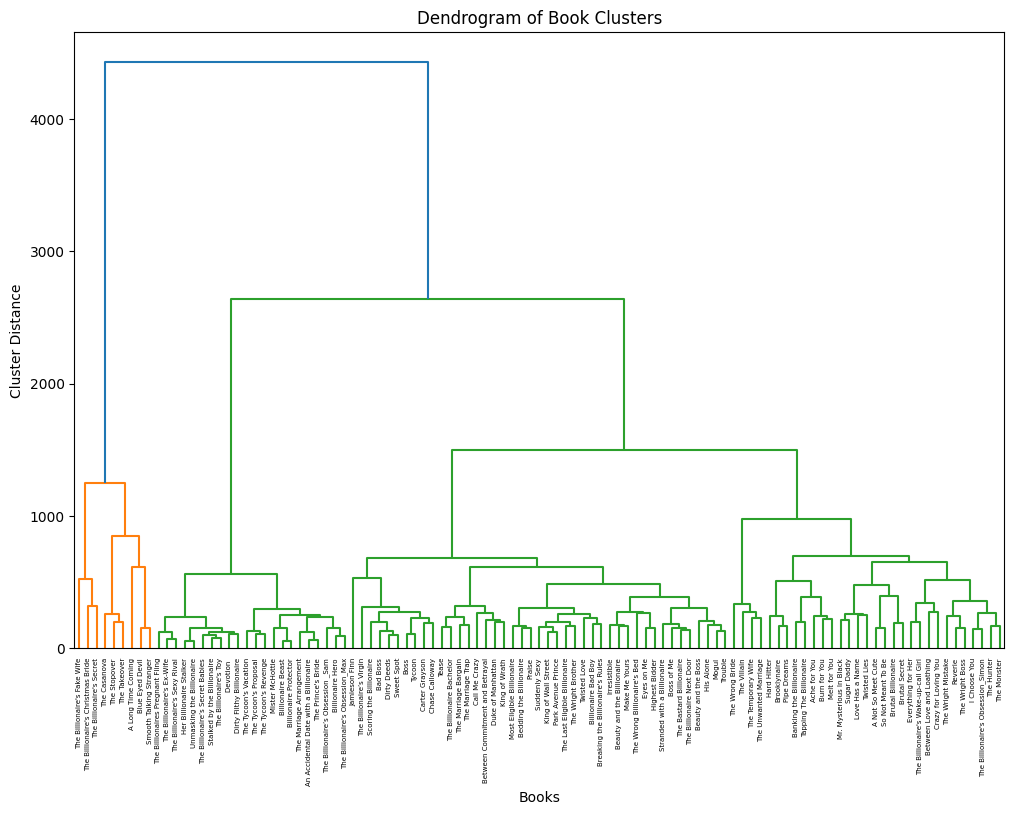

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(df_theme_distribution, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=df_theme_distribution.index, leaf_rotation=90)
plt.title("Dendrogram of Book Clusters")
plt.xlabel("Books")
plt.ylabel("Cluster Distance")
plt.show()

In [40]:
# Group by cluster label and calculate the average for each theme
average_theme_distribution = df_theme_distribution.groupby('Cluster_Label').mean()

# Display the top 5 themes per cluster for interpretability
for cluster_label in average_theme_distribution.index:
    top_themes = average_theme_distribution.loc[cluster_label].nlargest(5)
    print(f"Cluster {cluster_label} Top Themes: {top_themes.index.tolist()}")
    print(f"Values: {top_themes.values}\n")

Cluster 1 Top Themes: ['Communication', 'Inner Conflicts and Decisions', 'Happy Emotions, Calm and Peace', 'Softer Erotic', 'Domestic Environment']
Values: [1390.          409.66666667  285.          266.66666667  264.        ]

Cluster 2 Top Themes: ['Communication', 'Happy Emotions, Calm and Peace', 'Domestic Environment', 'Softer Erotic', 'Luxury Living']
Values: [1245.5   512.25  335.5   300.    295.5 ]

Cluster 3 Top Themes: ['Communication', 'Inner Conflicts and Decisions', 'Highly Explicit Erotic', 'Softer Erotic', 'Happy Emotions, Calm and Peace']
Values: [815.5  391.25 363.   358.   231.25]

Cluster 4 Top Themes: ['Communication', 'Happy Emotions, Calm and Peace', 'Inner Conflicts and Decisions', 'Softer Erotic', 'Domestic Environment']
Values: [336.   189.75 170.25 159.25 128.75]

Cluster 5 Top Themes: ['Communication', 'Happy Emotions, Calm and Peace', 'Domestic Environment', 'Courtship and Flirting', 'Softer Erotic']
Values: [385.  201.  165.5 152.5 124. ]

Cluster 6 Top Th

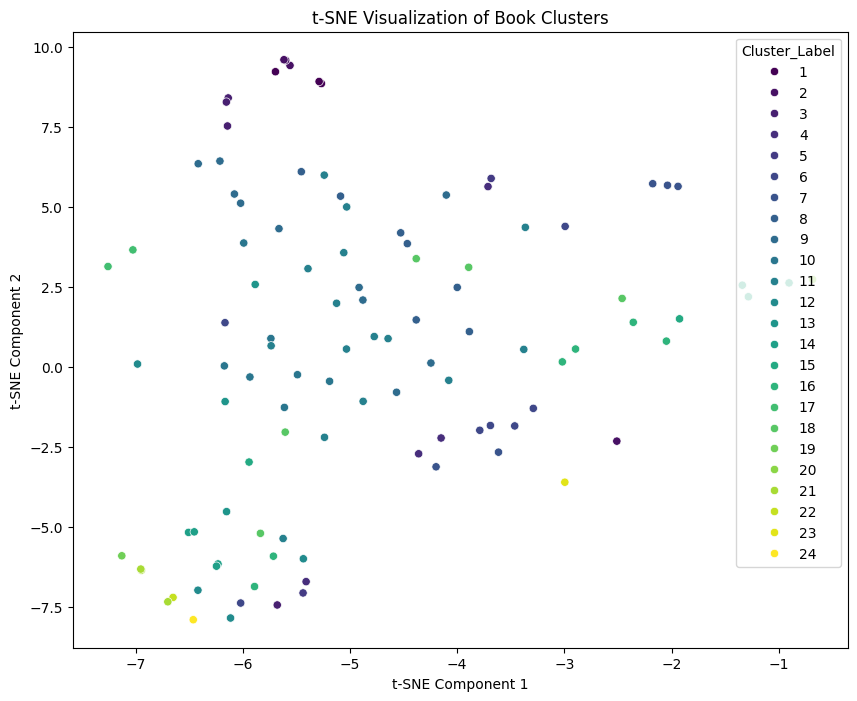

In [41]:
from sklearn.manifold import TSNE
import seaborn as sns

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(df_theme_distribution.drop(columns=['Cluster_Label']))

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df_theme_distribution['Cluster_Label'], palette="viridis", legend='full')
plt.title("t-SNE Visualization of Book Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [42]:
from sklearn.metrics import silhouette_score

# Prepare the data without the cluster label
X = df_theme_distribution.drop(columns=['Cluster_Label'])

# Calculate silhouette score for the current clusters
silhouette_avg = silhouette_score(X, df_theme_distribution['Cluster_Label'])
print(f"Silhouette Score for Current Clustering: {silhouette_avg}")

Silhouette Score for Current Clustering: -0.1012688112076926


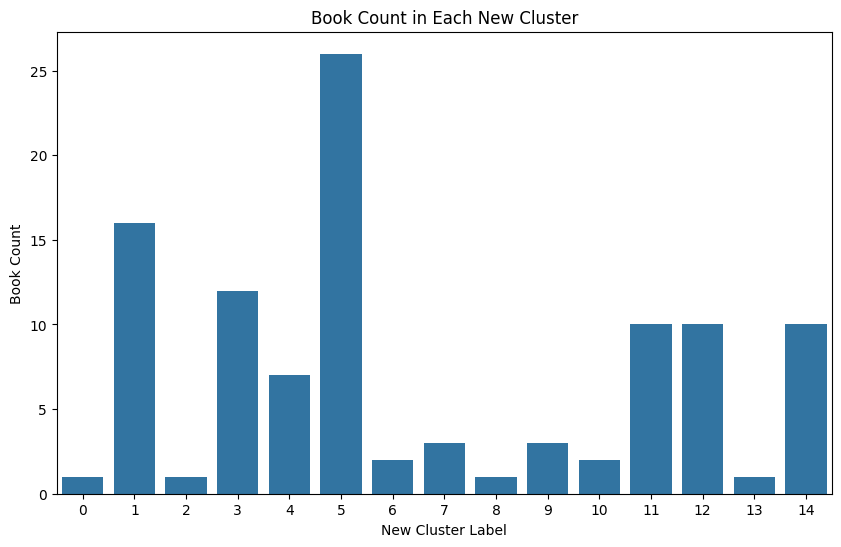

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Redefine clustering with fewer clusters
num_clusters = 15  # Try reducing cluster count
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_theme_distribution['New_Cluster_Label'] = kmeans.fit_predict(df_theme_distribution.drop(columns='Cluster_Label'))

# Visualize the new cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='New_Cluster_Label', data=df_theme_distribution)
plt.title("Book Count in Each New Cluster")
plt.xlabel("New Cluster Label")
plt.ylabel("Book Count")
plt.show()

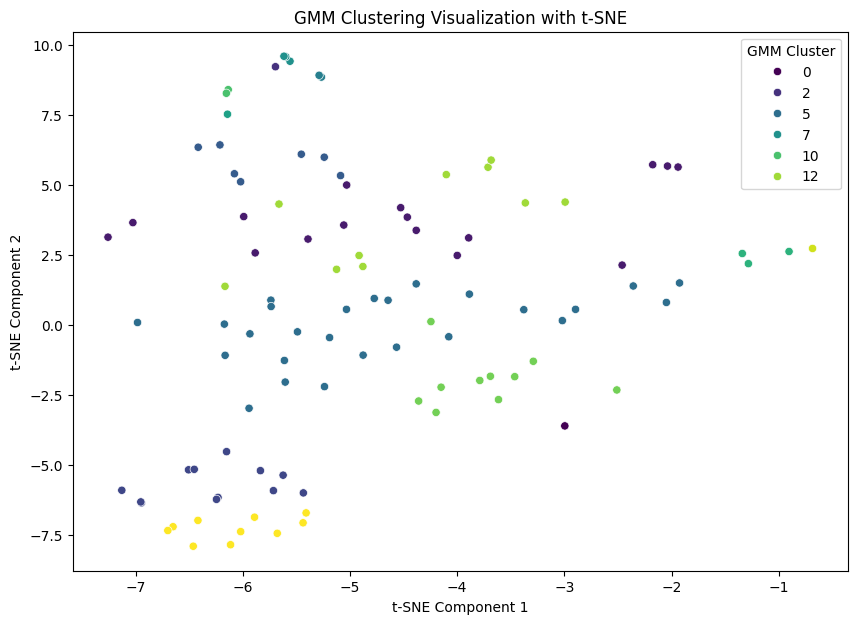

In [44]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=num_clusters, random_state=42)
df_theme_distribution['GMM_Cluster'] = gmm.fit_predict(df_theme_distribution.drop(columns='Cluster_Label'))

# t-SNE for visualization of GMM clusters
tsne_gmm = TSNE(n_components=2, random_state=42)
tsne_gmm_results = tsne_gmm.fit_transform(df_theme_distribution.drop(columns=['Cluster_Label', 'New_Cluster_Label', 'GMM_Cluster']))

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_gmm_results[:, 0], y=tsne_gmm_results[:, 1], hue=df_theme_distribution['GMM_Cluster'], palette='viridis')
plt.title("GMM Clustering Visualization with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="GMM Cluster")
plt.show()

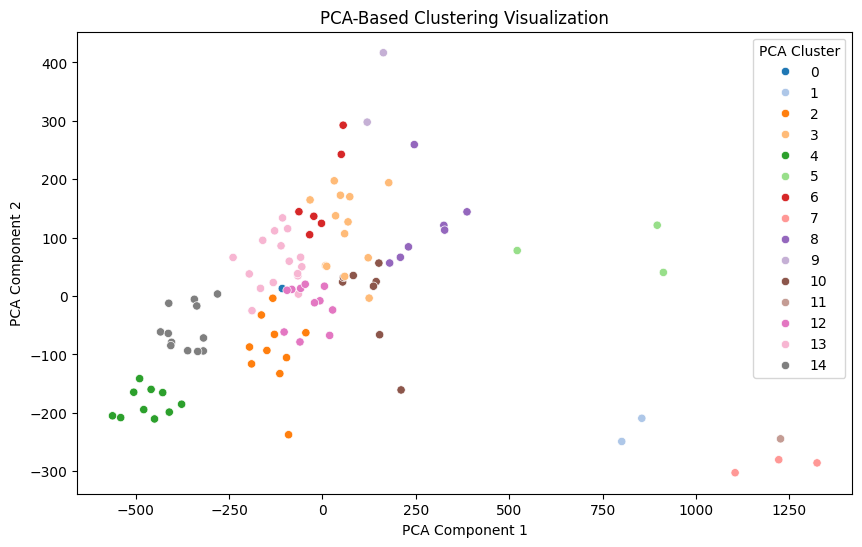

In [45]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)  # Reduce dimensions before clustering
reduced_data = pca.fit_transform(df_theme_distribution.drop(columns=['Cluster_Label', 'New_Cluster_Label', 'GMM_Cluster']))

# Re-apply clustering on reduced data
kmeans_reduced = KMeans(n_clusters=num_clusters, random_state=42)
df_theme_distribution['PCA_Cluster'] = kmeans_reduced.fit_predict(reduced_data)

# Visualization of PCA clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df_theme_distribution['PCA_Cluster'], palette='tab20')
plt.title("PCA-Based Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="PCA Cluster")
plt.show()

In [46]:
# Analyze top themes in each refined cluster
refined_clusters = df_theme_distribution.groupby('PCA_Cluster').mean()

# Print top themes per refined cluster
for cluster_id, row in refined_clusters.iterrows():
    top_themes = row.sort_values(ascending=False).head(5)
    print(f"\nRefined Cluster {cluster_id} Top Themes:")
    print(top_themes)


Refined Cluster 0 Top Themes:
Medical Care                      340.0
Communication                     289.0
Inner Conflicts and Decisions     278.0
Happy Emotions, Calm and Peace    250.0
Domestic Environment              233.0
Name: 0, dtype: float64

Refined Cluster 1 Top Themes:
Communication                     1263.0
Inner Conflicts and Decisions      430.5
Happy Emotions, Calm and Peace     276.5
Domestic Environment               244.0
Softer Erotic                      238.0
Name: 1, dtype: float64

Refined Cluster 2 Top Themes:
Communication                     311.5
Happy Emotions, Calm and Peace    240.2
Inner Conflicts and Decisions     179.5
Domestic Environment              139.3
Courtship and Flirting            138.6
Name: 2, dtype: float64

Refined Cluster 3 Top Themes:
Communication                     395.461538
Inner Conflicts and Decisions     362.153846
Courtship and Flirting            263.692308
Softer Erotic                     225.000000
Happy Emotions, Cal